In [1]:
"""Analyze preference menus."""
from collections import Counter, defaultdict
from pathlib import Path
import json
import re

from titlecase import titlecase
import numpy as np
import pandas as pd
import seaborn as sns
import urllib
import matplotlib.pyplot as plt

from consent.util.default_path import get_data_dir
from consent.cmp.comply.cookie_match import resolve_host_declaration
from ooutil.cookie_util import parse_cookie_str, url_domain_match
from ooutil.type_util import hashabledict
from ooutil.url_util import get_suffixed_domain


# data_dir = get_data_dir('2021-04-27/pref_menu_scan')
# data_dir = get_data_dir('2021-04-28/pref_menu_scan')
# data_dir = get_data_dir('2021-04-30/pref_menu_scan')
# data_dir = get_data_dir('2021-05-01/pref_menu_scan')
data_dir = get_data_dir('2021-05-03/pref_menu_scan_cleanstart')

fig_dir = Path.home() / 'local_projects/consent/paper/sp22/figures'
assert fig_dir.exists() and fig_dir.is_dir()

In [2]:
scanned_sites = [site_dir.name for site_dir in data_dir.glob('*') if site_dir.is_dir()]
site_dirs = [data_dir / site for site in scanned_sites]
print("Number of scanned sites:", len(scanned_sites))

Number of scanned sites: 227


In [3]:
def read_scan_result(site_dir):
    site_name = site_dir.name
    scan_file = site_dir / 'scan.json'
    if not scan_file.exists():
        return {}
    return json.loads(scan_file.read_text())

def read_scan_results(site_dirs):
    scans = []
    for site_dir in site_dirs:
        scans.append(read_scan_result(site_dir))
    return pd.DataFrame(scans)

raw_scans = read_scan_results(site_dirs)
scans = raw_scans[ ~raw_scans.failed.isna() & ~raw_scans['category'].isna() ]
scans = scans[ scans.failed == False ]
scans = scans.explode('category').reset_index(drop=True)
print("Number of domains:", scans.domain.nunique())
scans

Number of domains: 206


,domain,failed,failed_reason,pref_menu_type,category
0,siemens.com,False,None,accordion,"{'id': 'C0001', 'name': 'Strictly necessary co..."
1,siemens.com,False,None,accordion,"{'id': 'C0002', 'name': 'Performance cookies',..."
2,siemens.com,False,None,accordion,"{'id': 'C0003', 'name': 'Functionality cookies..."
3,siemens.com,False,None,accordion,"{'id': 'C0004', 'name': 'Marketing cookies', '..."
4,healthgrades.com,False,None,tab,"{'id': 'C0001', 'name': 'Strictly Necessary Co..."
...,...,...,...,...,...
790,bestwestern.com,False,None,tab,"{'id': 'SPD_BG', 'name': 'Other Third Party Co..."
791,sendinblue.com,False,None,tab,"{'id': 'C0001', 'name': 'Strictly Necessary Co..."
792,sendinblue.com,False,None,tab,"{'id': 'C0003', 'name': 'Functional Cookies', ..."
793,sendinblue.com,False,None,tab,"{'id': 'C0002', 'name': 'Performance Cookies',..."


In [4]:
hard_cases = {'askubuntu.com', 'mediaroom.com', 'prweb.com', 'prnewswire.com', 'newswire.ca', 'akamai.com', 'stackoverflow.com', 'businesswire.com'} # prweb, newswire, mediaroom: belong to cision, #businesswire does not have host in vendor items
iab_cases = {'discogs.com', 'wired.co.uk', 'vogue.co.uk'} # iab categories by onetrust, use another cookies to store consent.
fail_cases = set(scanned_sites) - set(scans.domain) - hard_cases - iab_cases
print(f"Failed to extract domains: {len(fail_cases)} {fail_cases}")

Failed to extract domains: 11 {'flashscore.com', 'cookielaw.org', 'bmj.com', 'superuser.com', 'eurogamer.net', 'kodak.com', 'mimecast.com', 'livescore.com', 'popsci.com', 'sketchup.com', 'hp.com'}


In [5]:
# pd.DataFrame(scans['category'].tolist())
scans = scans.join(pd.DataFrame(scans['category'].tolist()))
scans

,domain,failed,failed_reason,pref_menu_type,category,id,name,prev_status,cur_status
0,siemens.com,False,None,accordion,"{'id': 'C0001', 'name': 'Strictly necessary co...",C0001,Strictly necessary cookies,always_active,always_active
1,siemens.com,False,None,accordion,"{'id': 'C0002', 'name': 'Performance cookies',...",C0002,Performance cookies,false,false
2,siemens.com,False,None,accordion,"{'id': 'C0003', 'name': 'Functionality cookies...",C0003,Functionality cookies,false,false
3,siemens.com,False,None,accordion,"{'id': 'C0004', 'name': 'Marketing cookies', '...",C0004,Marketing cookies,false,false
4,healthgrades.com,False,None,tab,"{'id': 'C0001', 'name': 'Strictly Necessary Co...",C0001,Strictly Necessary Cookies,unavailable,unavailable
...,...,...,...,...,...,...,...,...,...
790,bestwestern.com,False,None,tab,"{'id': 'SPD_BG', 'name': 'Other Third Party Co...",SPD_BG,Other Third Party Cookies,true,false
791,sendinblue.com,False,None,tab,"{'id': 'C0001', 'name': 'Strictly Necessary Co...",C0001,Strictly Necessary Cookies,unavailable,unavailable
792,sendinblue.com,False,None,tab,"{'id': 'C0003', 'name': 'Functional Cookies', ...",C0003,Functional Cookies,true,false
793,sendinblue.com,False,None,tab,"{'id': 'C0002', 'name': 'Performance Cookies',...",C0002,Performance Cookies,true,false


In [6]:
no_choice_domains = []
for domain, group in scans.groupby('domain'):
    nvalues = group['prev_status'].nunique()
    if nvalues == 1 and group['prev_status'].unique()[0] in ['unavailable', 'always_active']: # , f"{group['prev_status'].unique()=} {domain=}"
        no_choice_domains.append(domain)
n_no_choices = len(no_choice_domains)
domains = set(scans.domain.unique())
n_domains = len(domains)
print(f"Number extracted domains: {n_domains}")
print(f"Number of no choice domains: {n_no_choices} ({n_no_choices / n_domains * 100:.2f}%)")

Number extracted domains: 206
Number of no choice domains: 48 (23.30%)


In [7]:
# no_choice_domains

In [8]:
tcf_sites_file = Path('/home/ducbui/Dropbox/projects/optout/data/2021-03-07/tcf_topsites/tcf_sites.json')
tcf_sites = pd.read_json(tcf_sites_file)
tcf_domains = set(tcf_sites.domain.tolist())

In [9]:
raw_scan_sites = set(raw_scans.domain.unique().tolist())
raw_scan_sites_with_tcf = raw_scan_sites.intersection(tcf_domains)
print(f"Number raw scanned with tcf: {len(raw_scan_sites_with_tcf)}")

scan_sites = set(scans.domain.unique().tolist())
scan_sites_with_tcf = scan_sites.intersection(tcf_domains)
print(f"Number extracted with tcf: {len(scan_sites_with_tcf)}")

Number raw scanned with tcf: 9
Number extracted with tcf: 2


## How many categories?

In [10]:
def normalize_name(name):
    name = name.lower()
    name = name.replace('personal information', 'personal data')
    parts = name.split()
    if 'manage' in name:
        print(parts)
    if len(parts) > 3 and parts[-3] == '/' and parts[-2] == 'manage' and parts[-1] == 'cookies':
        parts = parts[:-3]

    if len(parts) > 2 and parts[-2] == 'website' and parts[-1] == 'cookies':
        parts = parts[:-2]

    if parts[-1] == 'cookies':
        del parts[-1]
    
    result = ' '.join(parts)
    # if result in ['necessary', 'required', 'essential']:
    #     result = 'strictly necessary'

    return titlecase(result)

scans['norm_name'] = scans['name'].map(normalize_name)
scans

['sale', 'of', 'personal', 'data', '/', 'manage', 'cookies']


,domain,failed,failed_reason,pref_menu_type,category,id,name,prev_status,cur_status,norm_name
0,siemens.com,False,None,accordion,"{'id': 'C0001', 'name': 'Strictly necessary co...",C0001,Strictly necessary cookies,always_active,always_active,Strictly Necessary
1,siemens.com,False,None,accordion,"{'id': 'C0002', 'name': 'Performance cookies',...",C0002,Performance cookies,false,false,Performance
2,siemens.com,False,None,accordion,"{'id': 'C0003', 'name': 'Functionality cookies...",C0003,Functionality cookies,false,false,Functionality
3,siemens.com,False,None,accordion,"{'id': 'C0004', 'name': 'Marketing cookies', '...",C0004,Marketing cookies,false,false,Marketing
4,healthgrades.com,False,None,tab,"{'id': 'C0001', 'name': 'Strictly Necessary Co...",C0001,Strictly Necessary Cookies,unavailable,unavailable,Strictly Necessary
...,...,...,...,...,...,...,...,...,...,...
790,bestwestern.com,False,None,tab,"{'id': 'SPD_BG', 'name': 'Other Third Party Co...",SPD_BG,Other Third Party Cookies,true,false,Other Third Party
791,sendinblue.com,False,None,tab,"{'id': 'C0001', 'name': 'Strictly Necessary Co...",C0001,Strictly Necessary Cookies,unavailable,unavailable,Strictly Necessary
792,sendinblue.com,False,None,tab,"{'id': 'C0003', 'name': 'Functional Cookies', ...",C0003,Functional Cookies,true,false,Functional
793,sendinblue.com,False,None,tab,"{'id': 'C0002', 'name': 'Performance Cookies',...",C0002,Performance Cookies,true,false,Performance


In [11]:
# scans[scans.norm_name.str.contains('Sale')]

In [12]:
cat_to_count = Counter()
necessary_domains = set()
domain_to_ncats = {}
non_necessary_domains = []
for domain, group in scans.groupby('domain'):
    domain_categories = group.norm_name.tolist()
    cat_to_count.update(domain_categories)
    # if not any(nec in cat for nec in ['Necessary', 'Required', 'Essential', 'Core'] for cat in domain_categories):
    if all('Strictly Necessary' != cat for cat in domain_categories):
        print(domain_categories)
        non_necessary_domains.append(domain)
    else:
        necessary_domains.add(domain)
    domain_to_ncats[domain] = len(domain_categories)
print(f"Num cat names: {len(cat_to_count)}")
print(f"{len(non_necessary_domains)=} {len(necessary_domains)=}")
print(f"{non_necessary_domains=}")
cat_to_count.most_common(3)

['Essential', 'Performance', 'Sale of Personal Data']
['Essential', 'Functional', 'Performance', 'Targeting']
['Operate the Site and Core Services', 'Measure Performance', 'Extend Functionality', 'Personalize Advertising']
['Essential', 'Functional', 'Analytics', 'Advertising']
['Necessary', 'Performance (Or Analytics)', 'Functionality', 'Advertising']
['Essential', 'Performance and Functionality', 'Advertising (Targeting)', 'Analytics and Customization']
['Essential', 'Performance and Functionality', 'Advertising (Targeting)', 'Analytics and Customization']
['Necessary', 'Preference', 'Performance', 'Marketing']
['Necessary', 'Analytics', 'Personalization']
['Strictly Necessary & Analytics', 'Marketing & Targeting', 'Functional', 'Performance']
['Required', 'Functional', 'Advertising']
['Strictly Necessary and Site Functionality', 'Allow Sale of My Personal Data']
['Essential', 'Performance', 'Sale of Personal Data']
['Required', 'Functional', 'Advertising']
['Necessary', 'Performance

[('Strictly Necessary', 171), ('Performance', 142), ('Functional', 138)]

In [13]:
# Number of categories per site
ncats = list(domain_to_ncats.values())
print(f"Number of categories per domain: {np.mean(ncats):.2f} ({np.std(ncats):.2f} SD) min: {np.min(ncats)} max: {np.max(ncats)}")

Number of categories per domain: 3.86 (1.07 SD) min: 2 max: 8


In [14]:
domain_to_ncats_df = pd.DataFrame(list(domain_to_ncats.items()),columns=['domain','ncats']) 
# ax = sns.barplot(x='domain', y='ncats', data=domain_to_ncats_df); ticks = plt.xticks(rotation=45, ha='right')
assert len(domain_to_ncats_df[domain_to_ncats_df.ncats == 1]) == 0, "There should not be any site with only 1 category"
print(domain_to_ncats_df[domain_to_ncats_df.ncats == 2].domain.tolist())

['bestwestern.com', 'bhg.com', 'blackboard.com', 'crunchyroll.com', 'dictionary.com', 'eonline.com', 'foodandwine.com', 'gmu.edu', 'hbo.com', 'health.com', 'ikea.com', 'legacy.com', 'lexico.com', 'marthastewart.com', 'mensjournal.com', 'michaels.com', 'nwsource.com', 'patch.com', 'qz.com', 'realsimple.com', 'screencast.com', 'seattletimes.com', 'shape.com', 'techsmith.com', 'thesaurus.com', 'travelandleisure.com', 'tribalfusion.com', 'udemy.com']


In [15]:
cat_names = scans['norm_name'].value_counts()
cat_names = cat_names.to_frame().reset_index().sort_values(by=['norm_name', 'index'], ascending=[False, True])
n_sites = scans.domain.nunique()
cat_names['norm_name_percent'] = cat_names['norm_name'] / n_sites * 100
cat_names['num_sites'] = cat_names.apply(lambda row: f"{row['norm_name_percent']:.2f}% ({row['norm_name']}/{n_sites})", axis=1)
cat_names


,index,norm_name,norm_name_percent,num_sites
0,Strictly Necessary,171,83.009709,83.01% (171/206)
1,Performance,142,68.932039,68.93% (142/206)
2,Functional,138,66.990291,66.99% (138/206)
3,Targeting,130,63.106796,63.11% (130/206)
4,Social Media,38,18.446602,18.45% (38/206)
5,Advertising,18,8.737864,8.74% (18/206)
6,Sale of Personal Data,15,7.281553,7.28% (15/206)
7,Essential,14,6.796117,6.80% (14/206)
8,Marketing,10,4.854369,4.85% (10/206)
9,Analytics,9,4.368932,4.37% (9/206)


In [16]:
print(f"Number of category names: {len(cat_names)}")
print(f"Number of category with only 1 occurrence: {len(cat_names[cat_names.norm_name == 1])}")

Number of category names: 55
Number of category with only 1 occurrence: 28


In [17]:
latex = cat_names.head(10)[['index', 'num_sites']]
latex = latex.rename(columns={'index': 'Cookie Category', 'num_sites': '# Websites'})
latex.index = range(1, len(latex)+1)
print(latex.to_latex(index=True))

\begin{tabular}{lll}
\toprule
{} &        Cookie Category &        \# Websites \\
\midrule
1  &     Strictly Necessary &  83.01\% (171/206) \\
2  &            Performance &  68.93\% (142/206) \\
3  &             Functional &  66.99\% (138/206) \\
4  &              Targeting &  63.11\% (130/206) \\
5  &           Social Media &   18.45\% (38/206) \\
6  &            Advertising &    8.74\% (18/206) \\
7  &  Sale of Personal Data &    7.28\% (15/206) \\
8  &              Essential &    6.80\% (14/206) \\
9  &              Marketing &    4.85\% (10/206) \\
10 &              Analytics &     4.37\% (9/206) \\
\bottomrule
\end{tabular}



Written to /home/ducbui/local_projects/consent/paper/sp22/figures/cookie_category.png


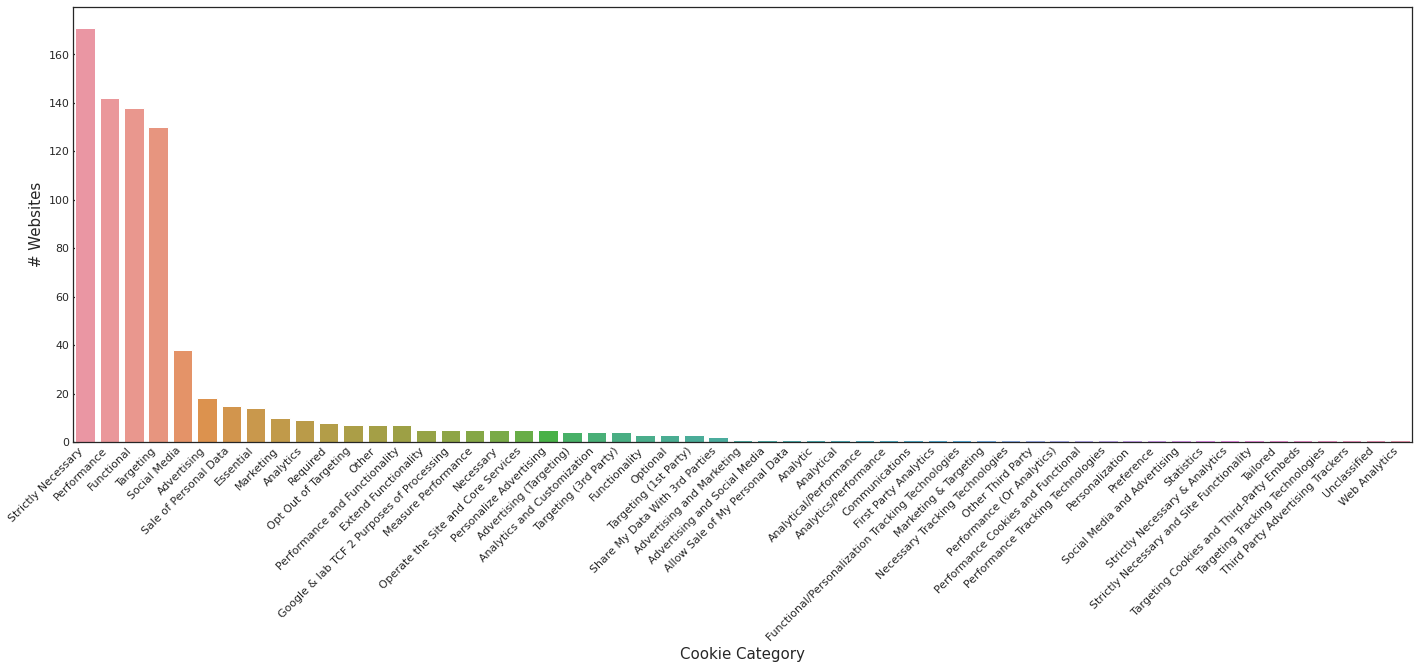

In [18]:
sns.set(rc={'figure.figsize':(24,8),"font.size":25,"axes.titlesize":25,"axes.labelsize":15},style="white", font_scale = 1)
ax = sns.barplot(x=cat_names['index'], y=cat_names.norm_name)
ticks = plt.xticks(rotation=45, ha='right')

ax.tick_params(left=True, bottom=False, direction="in")
ax.set_ylabel('# Websites')
ax.set_xlabel('Cookie Category')

out_file = fig_dir / 'cookie_category.png'; plt.savefig(out_file, dpi=200, bbox_inches='tight'); print(f"Written to {out_file}")

## How many cookies/category?

In [19]:
from consent.data.site_pref import read_site_prefs

In [20]:
scanned_sites = [site_dir.name for site_dir in data_dir.glob('*') if site_dir.is_dir()]
site_dirs = [data_dir / site for site in scanned_sites]
print("Number of scanned sites:", len(scanned_sites)) # , scanned_sites)
site_prefs = read_site_prefs(site_dirs)
site_prefs

Number of scanned sites: 227
Contain duplicates: Before 12937, after drop duplicates: 12927


,duration,host,name,group_id,site,consent
0,Session,healthgrades.com,_vapi,C0001,healthgrades.com,True
1,365 days,partners.healthgrades.com,OptanonConsent,C0001,healthgrades.com,True
2,a few seconds,healthgrades.com,_dc_gtm_UA-xxxxxxxx,C0001,healthgrades.com,True
3,2914169 days,partners.healthgrades.com,eupubconsent,C0001,healthgrades.com,True
4,365 days,healthgrades.com,OptanonAlertBoxClosed,C0001,healthgrades.com,True
...,...,...,...,...,...,...
12932,390 days,yieldoptimizer.com,ph,SPD_BG,bestwestern.com,False
12933,390 days,yieldoptimizer.com,dph,SPD_BG,bestwestern.com,False
12934,390 days,yieldoptimizer.com,gcma,SPD_BG,bestwestern.com,False
12935,390 days,yieldoptimizer.com,ckid,SPD_BG,bestwestern.com,False


In [21]:
cookielist_sites = sorted(site_prefs.site.unique().tolist())
n_cookielist_sites = len(cookielist_sites)
assert site_prefs.site.nunique() == n_cookielist_sites
print("Sites with cookie list:", n_cookielist_sites, cookielist_sites)

Sites with cookie list: 83 ['accorhotels.com', 'adtelligent.com', 'apachefriends.org', 'behance.net', 'bestwestern.com', 'biomedcentral.com', 'bitnami.com', 'bodybuilding.com', 'britishcouncil.org', 'callofduty.com', 'canon.com', 'cell.com', 'chanel.com', 'christies.com', 'cloudflare.com', 'cnet.com', 'commonsensemedia.org', 'corel.com', 'digicert.com', 'digitalspy.com', 'documentforce.com', 'download.com', 'elsevier.com', 'elsevierhealth.com', 'exacttarget.com', 'exoclick.com', 'fairmont.com', 'fendi.com', 'force.com', 'gamespot.com', 'glassdoor.co.in', 'glassdoor.com', 'goal.com', 'healthgrades.com', 'home.kpmg', 'hotjar.com', 'irishtimes.com', 'kpmg.com', 'magento.com', 'mango.com', 'marketo.com', 'mcdonalds.com', 'media.net', 'mendeley.com', 'metacritic.com', 'myportfolio.com', 'nature.com', 'netflix.com', 'news24.com', 'nflxvideo.net', 'oclc.org', 'onetrust.com', 'pardot.com', 'payoneer.com', 'pendo.io', 'rapidssl.com', 'redbull.com', 'rte.ie', 'salesforce.com', 'scientificamerica

In [22]:
def get_cat_name(site, group_id):
    found = scans[ (scans.domain == site) & (scans['id'] == group_id)]
    assert len(found) == 1
    return found.iloc[0]['norm_name']
site_prefs['norm_name'] = site_prefs.apply(lambda row: get_cat_name(row['site'], row['group_id']), axis=1)
site_prefs

,duration,host,name,group_id,site,consent,norm_name
0,Session,healthgrades.com,_vapi,C0001,healthgrades.com,True,Strictly Necessary
1,365 days,partners.healthgrades.com,OptanonConsent,C0001,healthgrades.com,True,Strictly Necessary
2,a few seconds,healthgrades.com,_dc_gtm_UA-xxxxxxxx,C0001,healthgrades.com,True,Strictly Necessary
3,2914169 days,partners.healthgrades.com,eupubconsent,C0001,healthgrades.com,True,Strictly Necessary
4,365 days,healthgrades.com,OptanonAlertBoxClosed,C0001,healthgrades.com,True,Strictly Necessary
...,...,...,...,...,...,...,...
12932,390 days,yieldoptimizer.com,ph,SPD_BG,bestwestern.com,False,Other Third Party
12933,390 days,yieldoptimizer.com,dph,SPD_BG,bestwestern.com,False,Other Third Party
12934,390 days,yieldoptimizer.com,gcma,SPD_BG,bestwestern.com,False,Other Third Party
12935,390 days,yieldoptimizer.com,ckid,SPD_BG,bestwestern.com,False,Other Third Party


In [23]:
site_prefs[ (site_prefs.site == 'fendi.com') ]

,duration,host,name,group_id,site,consent,norm_name
499,Session,www.fendi.com,JSESSIONID,C0001,fendi.com,True,Strictly Necessary
500,a few seconds,fendi.com,_dc_gtm_UA-xxxxxxxx,C0001,fendi.com,True,Strictly Necessary
501,Session,www.fendi.com,AWSELB,C0001,fendi.com,True,Strictly Necessary
502,365 days,fendi.com,OptanonConsent,C0001,fendi.com,True,Strictly Necessary
503,3000 days,www.fendi.com,f_nl_count,C0001,fendi.com,True,Strictly Necessary
...,...,...,...,...,...,...,...
572,397 days,addthis.com,xtc,C0004,fendi.com,False,Targeting
573,730 days,atdmt.com,ATN,C0004,fendi.com,False,Targeting
574,Session,youtube.com,YSC,C0004,fendi.com,False,Targeting
575,180 days,youtube.com,VISITOR_INFO1_LIVE,C0004,fendi.com,False,Targeting


In [24]:
def get_num_cookies(site, norm_name):
    group = site_prefs[ (site_prefs.site == site) & (site_prefs.norm_name == norm_name) ][['host', 'name']]
    if len(group) != len(group.drop_duplicates()):
        print(f'WARNING: there should be no duplicate per category {site=}')
        print(group)
    return len(group.drop_duplicates())

site_ncookies_data = defaultdict(list)
for site in site_prefs.site.unique():
    site_ncookies_data['site'].append(site)
    for norm_name in site_prefs.norm_name.unique():
        site_ncookies_data[norm_name].append(get_num_cookies(site, norm_name))
    site_ncookies_data['all_cookies'].append(len(site_prefs[ (site_prefs.site == site) ]))
site_ncookies = pd.DataFrame(site_ncookies_data)
site_ncookies
# name_to_ncookies = {norm_name: get_num_cookies(norm_name) for norm_name in site_prefs.norm_name.unique()}

                 host                name
552         fendi.com                _fbp
553     www.fendi.com       _cs_same_site
554         fendi.com     _cs_root-domain
555         fendi.com             _uetsid
556         fendi.com               _scid
557         yahoo.com                  A3
558         yahoo.com                   B
559         yahoo.com                   B
560          bing.com                MUID
561          turn.com                 uid
562        google.com                 NID
563      facebook.com                  fr
564  www.facebook.com                    
565  flashtalking.com     flashtalkingad1
566    s7.addthis.com             __atuvs
567    s7.addthis.com             __atuvc
568   doubleclick.net                 IDE
569   doubleclick.net         test_cookie
570       addthis.com                 loc
571       addthis.com                 uvc
572       addthis.com                 xtc
573         atdmt.com                 ATN
574       youtube.com             

,site,Strictly Necessary,Performance,Functional,Targeting,Necessary,Performance (Or Analytics),Functionality,Advertising,Social Media,...,Personalization,Statistics,Communications,Optional,Analytics/Performance,Marketing & Targeting,Strictly Necessary & Analytics,Social Media and Advertising,Other Third Party,all_cookies
0,healthgrades.com,12,51,11,98,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,172
1,callofduty.com,0,0,0,0,16,14,6,53,0,...,0,0,0,0,0,0,0,0,0,89
2,britishcouncil.org,33,37,27,141,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,238
3,fendi.com,11,36,6,24,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,78
4,gamespot.com,9,24,5,117,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,tvguide.com,8,23,9,167,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,208
79,statista.com,0,6,7,30,55,0,0,0,0,...,0,0,0,0,0,0,0,0,0,98
80,chanel.com,52,18,13,57,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,140
81,bitnami.com,6,10,0,0,0,0,0,16,2,...,0,0,0,0,0,0,0,0,0,34


In [25]:
site_ncookies.sort_values('all_cookies')

,site,Strictly Necessary,Performance,Functional,Targeting,Necessary,Performance (Or Analytics),Functionality,Advertising,Social Media,...,Personalization,Statistics,Communications,Optional,Analytics/Performance,Marketing & Targeting,Strictly Necessary & Analytics,Social Media and Advertising,Other Third Party,all_cookies
31,exoclick.com,4,0,0,0,0,0,0,4,0,...,0,0,0,0,0,0,0,0,0,11
46,apachefriends.org,2,7,0,0,0,0,0,6,0,...,0,0,0,0,0,0,0,0,0,15
41,warnerbros.com,11,4,1,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20
63,biomedcentral.com,4,9,1,3,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,30
57,springerlink.com,7,3,3,3,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,unity3d.com,50,64,48,256,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,418
10,unity.com,50,64,48,256,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,418
59,corel.com,19,22,11,448,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,500
7,magento.com,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,530


In [26]:
mean_site_cookies = site_ncookies.mean().sort_values(ascending=False).head(8)
mean_site_cookies

all_cookies                155.746988
Targeting                   52.325301
Performance                 17.204819
Strictly Necessary          16.951807
Functional                  15.373494
Advertising                 12.373494
Personalize Advertising     10.867470
Measure Performance          5.060241
dtype: float64

In [27]:
top_cats = mean_site_cookies.index.tolist()
# top_cats = cat_names.head(6)['index'].tolist()
site_ncookies[top_cats]

,all_cookies,Targeting,Performance,Strictly Necessary,Functional,Advertising,Personalize Advertising,Measure Performance
0,172,98,51,12,11,0,0,0
1,89,0,0,0,0,53,0,0
2,238,141,37,33,27,0,0,0
3,78,24,36,11,6,0,0,0
4,155,117,24,9,5,0,0,0
...,...,...,...,...,...,...,...,...
78,208,167,23,8,9,0,0,0
79,98,30,6,0,7,0,0,0
80,140,57,18,52,13,0,0,0
81,34,0,10,6,0,16,0,0


In [28]:
std_site_cookies = site_ncookies.std()
max_site_cookies = site_ncookies.max()
min_site_cookies = site_ncookies.min()
mean_site_cookies_data = defaultdict(list)
for cat in top_cats:
    mean_site_cookies_data['cat'].append(cat)
    mean_site_cookies_data['mean'].append(site_ncookies[cat].mean())
    mean_site_cookies_data['std'].append(site_ncookies[cat].std())
    mean_site_cookies_data['min'].append(site_ncookies[cat].min())
    mean_site_cookies_data['max'].append(site_ncookies[cat].max())
pd.DataFrame(mean_site_cookies_data)

,cat,mean,std,min,max
0,all_cookies,155.746988,133.582243,11,643
1,Targeting,52.325301,81.315271,0,448
2,Performance,17.204819,20.285619,0,99
3,Strictly Necessary,16.951807,22.536639,0,147
4,Functional,15.373494,30.475784,0,150
5,Advertising,12.373494,44.990164,0,338
6,Personalize Advertising,10.867470,48.983514,0,351
7,Measure Performance,5.060241,21.277120,0,115


In [29]:
print(f"Number of cookies in cookie lists: {len(site_prefs):,d}")

Number of cookies in cookie lists: 12,927


In [30]:
def get_unresolved_hosts():
    unresolved_hosts = Counter()
    for _, row in site_prefs.iterrows():
        try:
            resolve_host_declaration(row, row['site'])
        except ValueError:
            unresolved_hosts[row['host']] += 1
    return unresolved_hosts
# unresolved_hosts = get_unresolved_hosts()    
n_unresolves = sum(unresolved_hosts.values())
n_decls = len(site_prefs)
print(f"Number of resolved host in cookie declaration: {(1 - n_unresolves / n_decls) * 100}%")
print(f"Number of unresolved host in cookie declaration: {n_unresolves}")
unresolved_hosts

NameError: name 'unresolved_hosts' is not defined

## Analysis of Contradictory Preferences

In [29]:
# Get information of each categories: group id, editable, set of cookies (name, host)

def find_cookies(site, cat_info):
    """Return a set of tuples (name, host)."""
    found = site_prefs[ (site_prefs.site == site) & (site_prefs['group_id'] == cat_info['group_id']) ]
    return set((cookie['name'], cookie['host']) for _, cookie in found.iterrows())

def get_cat_infos(site, categories, verbose=0):
    for category in categories:
        if verbose >= 2: print(f"{category=}")
        prev_status = category['prev_status']
        cur_status = category['cur_status']
        if prev_status in ['unavailable', 'always_active']:
            assert cur_status == prev_status
            editable = False
        else:
            editable = True
        cat_info = {'editable': editable, 'group_id': category['id'], 'name': category['name']}
        cat_info['cookies'] = find_cookies(site, cat_info)
        yield cat_info

def find_contra_cookies(cat_info1, cat_info2):
    return list(cat_info1['cookies'].intersection(cat_info2['cookies']))

def find_contras(cat_infos, verbose=0):
    contras = []
    for i in range(len(cat_infos) - 1):
        for j in range(i + 1, len(cat_infos)):
            cat_info_i, cat_info_j = cat_infos[i], cat_infos[j]
            if cat_info_i['editable'] or cat_info_j['editable']:
                contra_cookies = find_contra_cookies(cat_info_i, cat_info_j)
                if len(contra_cookies) > 0:
                    if verbose >= 2: print(cat_info_i['name'], cat_info_j['name'], contra_cookies)
                    contras.append({'cat1': cat_info_i['name'], 'cat2': cat_info_j['name'], 'contras': contra_cookies})
    return contras

def get_scan_info(site):
    found = raw_scans[site == raw_scans.domain]
    assert len(found) == 1
    return found.iloc[0].to_dict()

def get_contras(verbose=0):
    found_contras = []
    for site in site_prefs.site.unique():
        # if site != 'vmware.com':            continue
        scan_info = get_scan_info(site)
        cat_infos = list(get_cat_infos(site, scan_info['category']))
        contras = find_contras(cat_infos)
        if len(contras) > 0:
            if verbose >= 2: print(site)
            for contra in contras:
                contra['site'] = site
                found_contras.append(contra)
    return pd.DataFrame(found_contras)

contra_sites = get_contras()
contra_sites = contra_sites.explode('contras').reset_index(drop=True)
contra_sites['contra_name'] = contra_sites.contras.map(lambda contra: contra[0])
contra_sites['contra_host'] = contra_sites.contras.map(lambda contra: contra[1])
contra_sites['contra_cats'] = contra_sites.apply(lambda row: f"{normalize_name(row['cat1'])}-{normalize_name(row['cat2'])}", axis=1)
contra_sites


,cat1,cat2,contras,site,contra_name,contra_host,contra_cats
0,Strictly Necessary,Advertising,"(AWSALBCORS, communities.vmware.com)",vmware.com,AWSALBCORS,communities.vmware.com,Strictly Necessary-Advertising
1,Strictly Necessary,Advertising,"(VISITOR_BEACON, communities.vmware.com)",vmware.com,VISITOR_BEACON,communities.vmware.com,Strictly Necessary-Advertising
2,Performance,Functional,"(AMCVS_5B29123F5245AD520A490D45%40AdobeOrg, vm...",vmware.com,AMCVS_5B29123F5245AD520A490D45%40AdobeOrg,vmware.com,Performance-Functional
3,Performance,Functional,"(AMCV_5B29123F5245AD520A490D45%40AdobeOrg, vmw...",vmware.com,AMCV_5B29123F5245AD520A490D45%40AdobeOrg,vmware.com,Performance-Functional
4,Performance,Advertising,"(test, vmware.com)",vmware.com,test,vmware.com,Performance-Advertising
...,...,...,...,...,...,...,...
134,Performance Cookies,Targeting Cookies,"(_gtld, elsevier.com)",elsevier.com,_gtld,elsevier.com,Performance-Targeting
135,Targeting Cookies,Optional Cookies,"(B, yahoo.com)",glassdoor.co.in,B,yahoo.com,Targeting-Optional
136,Functional Cookies,Advertising Cookies,"(language, www.slideshare.net)",pardot.com,language,www.slideshare.net,Functional-Advertising
137,Functional Cookies,Advertising Cookies,"(lpv1, pi.pardot.com)",pardot.com,lpv1,pi.pardot.com,Functional-Advertising


In [35]:
contra_cookies = contra_sites[['site', 'cat1', 'contra_name', 'contra_host']].drop_duplicates()
contra_cookies

,site,cat1,contra_name,contra_host
0,vmware.com,Strictly Necessary,AWSALBCORS,communities.vmware.com
1,vmware.com,Strictly Necessary,VISITOR_BEACON,communities.vmware.com
2,vmware.com,Performance,AMCVS_5B29123F5245AD520A490D45%40AdobeOrg,vmware.com
3,vmware.com,Performance,AMCV_5B29123F5245AD520A490D45%40AdobeOrg,vmware.com
4,vmware.com,Performance,test,vmware.com
...,...,...,...,...
134,elsevier.com,Performance Cookies,_gtld,elsevier.com
135,glassdoor.co.in,Targeting Cookies,B,yahoo.com
136,pardot.com,Functional Cookies,language,www.slideshare.net
137,pardot.com,Functional Cookies,lpv1,pi.pardot.com


In [36]:
print(f"Number of contra prefs: {len(contra_cookies)}, on {contra_cookies.site.nunique()} websites.")

Number of contra prefs: 78, on 22 websites.


In [37]:
print("Most common category pairs")
contra_sites.contra_cats.value_counts()

Most common category pairs


Strictly Necessary-Targeting                                  13
Performance-Targeting                                         13
Targeting-Social Media                                        11
Performance-Social Media                                      11
Strictly Necessary-Social Media                               10
Strictly Necessary-Performance                                10
Functional-Social Media                                       10
Functional-Targeting                                          10
Functional-Performance                                        10
Strictly Necessary-Functional                                 10
Targeting-Targeting (3rd Party)                                9
Functional-Advertising                                         6
Targeting-Targeting (1st Party)                                3
Strictly Necessary-Advertising                                 2
Operate the Site and Core Services-Personalize Advertising     2
Performance-Functional   

In [38]:
contra_cookies.contra_name.value_counts()

GoogleAdServingTest                          31
NID                                           8
language                                      5
CONSENT                                       4
tuuid_lu                                      2
__cfduid                                      2
google_push                                   2
test                                          2
c                                             2
__cf_bm                                       2
tuuid                                         2
_dlt                                          1
AWSALBCORS                                    1
dc                                            1
lpv1                                          1
EE                                            1
B                                             1
AMCVS_5B29123F5245AD520A490D45%40AdobeOrg     1
id                                            1
VISITOR_BEACON                                1
__insp_nv                               

In [43]:
contra_cookies[contra_cookies.contra_name == 'NID']

,site,cat1,contra_name,contra_host
14,fairmont.com,Strictly Necessary Cookies,NID,google.com
22,fairmont.com,Functional Cookies,NID,google.com
28,fairmont.com,Performance Cookies,NID,google.com
32,fairmont.com,Targeting Cookies,NID,google.com
53,accorhotels.com,Strictly Necessary Cookies,NID,google.com
85,accorhotels.com,Functional Cookies,NID,google.com
110,accorhotels.com,Performance Cookies,NID,google.com
125,accorhotels.com,Targeting Cookies,NID,google.com


In [33]:
raw_scans[raw_scans.domain == 'vmware.com'].iloc[0]['category']

[{'id': 'C0001',
  'name': 'Strictly Necessary',
  'prev_status': 'unavailable',
  'cur_status': 'unavailable'},
 {'id': 'C0002',
  'name': 'Performance',
  'prev_status': 'true',
  'cur_status': 'false'},
 {'id': 'C0003',
  'name': 'Functional',
  'prev_status': 'true',
  'cur_status': 'false'},
 {'id': 'C0004',
  'name': 'Advertising',
  'prev_status': 'true',
  'cur_status': 'false'},
 {'id': 'C0005',
  'name': 'Social Media',
  'prev_status': 'true',
  'cur_status': 'false'}]

## Analyze preference-cookie

In [43]:
# Read in the post-rejection cookies.
def get_brcookies():
    found_brcookies = []
    for site in scans.domain.unique():
        postrej_file = data_dir / site / 'postrej_cookies.json'
        if not postrej_file.exists():
            print(f"Warning: {postrej_file} not exist")
            continue
        for brcookie in json.loads(postrej_file.read_text())['browser_cookies']:
            brcookie['site'] = site
            found_brcookies.append(brcookie)
    return pd.DataFrame(found_brcookies)
brcookies = get_brcookies()
brcookies
    


,domain,expires,httpOnly,name,path,sameSite,secure,value,site
0,.siemens.com,-1.000000e+00,False,s_cc,/,None,False,true,siemens.com
1,.siemens.com,1.651627e+09,False,OptanonAlertBoxClosed,/,None,True,2021-05-04T01:24:38.671Z,siemens.com
2,.siemens.com,1.651627e+09,False,OptanonConsent,/,None,True,isIABGlobal=false&datestamp=Mon+May+03+2021+21...,siemens.com
3,assets.new.siemens.com,1.620696e+09,False,AWSALB,/,None,False,t5+th0fcH+Hbtk+jobCQjqOphUp9jgprWJuErdpItNQ7y3...,siemens.com
4,assets.new.siemens.com,1.620696e+09,False,AWSALBCORS,/,None,True,t5+th0fcH+Hbtk+jobCQjqOphUp9jgprWJuErdpItNQ7y3...,siemens.com
...,...,...,...,...,...,...,...,...,...
19562,.doubleclick.net,1.683164e+09,True,IDE,/,None,True,AHWqTUk1y_w5tZLqrd9Y-Gga9-umtHBCDAk5C2sKwckV2u...,sendinblue.com
19563,.sendinblue.com,1.651628e+09,False,OptanonAlertBoxClosed,/,Lax,False,2021-05-04T01:38:35.521Z,sendinblue.com
19564,.sendinblue.com,1.622684e+09,False,pricing_version,/,None,False,v2,sendinblue.com
19565,.sendinblue.com,1.622684e+09,False,localization,/,None,False,international,sendinblue.com


In [47]:
pref_cookies = brcookies[brcookies.name == 'OptanonConsent']
for _, row in pref_cookies.iterrows():
    if row['domain'] != '.' + row['site']:
        print("Restrictive consent scope:", row['site'], row['domain'])

Restrictive consent scope: www.fendi.com
Restrictive consent scope: .gisday.com
Restrictive consent scope: .arcgis.com
Restrictive consent scope: .www.ikea.com
Restrictive consent scope: .mailchimp.com
Restrictive consent scope: .supersonic.com
Restrictive consent scope: .home.kpmg
Restrictive consent scope: .netflix.com
Restrictive consent scope: www.mcdonalds.com
Restrictive consent scope: .www.viber.com
Restrictive consent scope: .axs.com
Restrictive consent scope: .www.salesforce.com
Restrictive consent scope: .www.fairmont.com
Restrictive consent scope: .airship.com
Restrictive consent scope: .www.cloudflare.com
Restrictive consent scope: .www.icims.com
Restrictive consent scope: .fastly.com
Restrictive consent scope: .amobee.com
Restrictive consent scope: .www.hindawi.com
Restrictive consent scope: .www.appannie.com
Restrictive consent scope: .vdx.tv
Restrictive consent scope: .www.flaticon.com
Restrictive consent scope: .www.salesforce.com
Restrictive consent scope: .adobe.com
R